## **1.) Import libraries and datasets**

In [7]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score

In [8]:
import sklearn.linear_model as lm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve, auc, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [9]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [24]:
df_response = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS7105 CRM/CLV4 (Week10) Campaign Response Model/Retail_Data_Response.csv')
df_transactions = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/์NIDA Class/BADS7105 CRM/CLV4 (Week10) Campaign Response Model/Retail_Data_Transactions.csv', parse_dates=['trans_date']) 
# parse_dates=['trans_date'] บอกว่า Column ไหนเป็น date

In [25]:
df_response.head()   # table นี้เป็น customer level, response คือ ตอบ/ไม่ตอบ ใช้/ไม่ใช้ campaign

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [26]:
df_transactions.head()        
# table level data ละเอียดกว่าอันบน table นี้เป็น transaction level เนื่องจากในตารางไม่มี trans_id จึงใช้ tran_date เป็นตัว identifier แทน 
# ซึ่งถ้าจะให้ table 2 อันนี้มา join กันยันทำไม่ได้ level ต่างกัน => เราต้องทำให้เป็น Customer level ให้ได้ => เพื่อมาชนกันได้พร้อมเข้า model 

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [27]:
# ทำ max/min เพื่อดูไปทำการ scope data ต่อ
print(df_transactions['trans_date'].min())    
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


### **EDA**

In [28]:
df_transactions['tran_amount'].describe()

count    125000.000000
mean         64.991912
std          22.860006
min          10.000000
25%          47.000000
50%          65.000000
75%          83.000000
max         105.000000
Name: tran_amount, dtype: float64

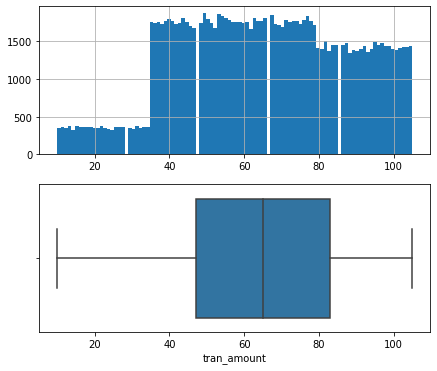

In [29]:
fig, axes = plt.subplots(2,1, figsize=(7,6))
df_transactions['tran_amount'].hist(bins=100, ax=axes[0])
sns.boxplot(data=df_transactions, x='tran_amount', ax=axes[1]);

### **Time series**

In [30]:
df_transactions['trans_date'].min(), df_transactions['trans_date'].max()

(Timestamp('2011-05-16 00:00:00'), Timestamp('2015-03-16 00:00:00'))

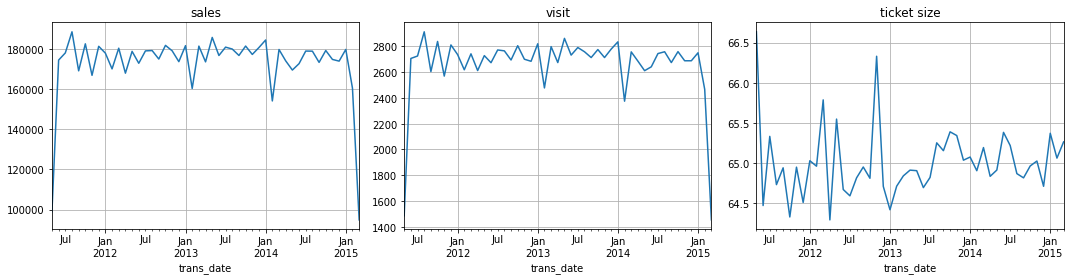

In [31]:
fig, axes = plt.subplots(1,3, figsize=(15,4), tight_layout=True)
axes = axes.ravel()

df_transactions.groupby(pd.Grouper(key='trans_date',freq='M'))['tran_amount'].sum().plot(title='sales', ax=axes[0])
df_transactions.groupby(pd.Grouper(key='trans_date',freq='M'))['tran_amount'].size().plot(title='visit', ax=axes[1])
df_transactions.groupby(pd.Grouper(key='trans_date',freq='M'))['tran_amount'].apply(lambda x: x.sum()/x.count()).plot(title='ticket size')
for ax in axes:
    ax.grid(True)

plt.show()

### **Cohort Analysis**

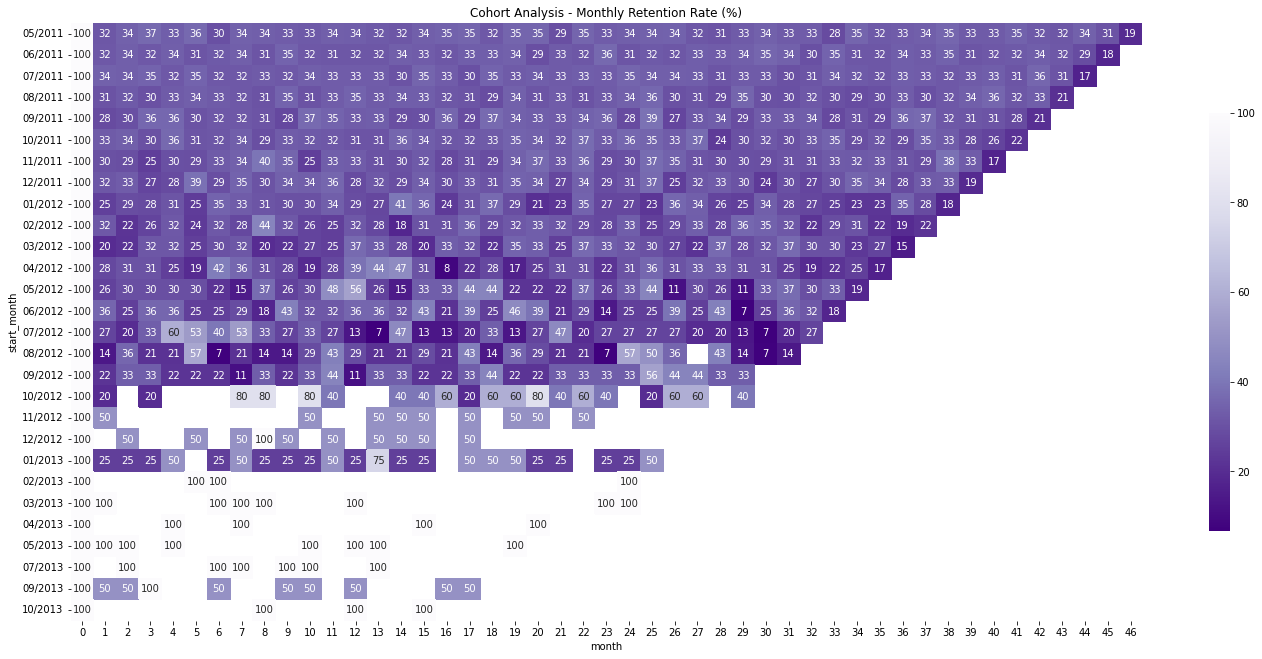

In [34]:
cohort = df_transactions.groupby(['customer_id', pd.Grouper(key='trans_date',freq='M')]).size().reset_index()
cohort['start_month'] = cohort['customer_id'].map(cohort.groupby('customer_id')['trans_date'].min())
cohort['month'] = cohort.apply(lambda x: (x['trans_date'].year - x['start_month'].year)*12 + (x['trans_date'].month - x['start_month'].month) , axis=1)
cohort = pd.pivot_table(cohort, index='start_month', columns='month', values='customer_id', aggfunc='count').sort_index()
cohort = cohort.divide(cohort.iloc[:,0], axis=0).multiply(100)
cohort.index = cohort.index.strftime('%m/%Y')
plt.figure(figsize=(24,11))
sns.heatmap(cohort, cmap='Purples_r', annot=True, fmt='.0f', cbar_kws={'shrink':.7})
# plt.yticks(cohort.index.strftime('%m/%Y'))
plt.title('Cohort Analysis - Monthly Retention Rate (%)');

## **2.) Data Preparation**

In [14]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015  ******
## RFM model will be used to predict campaign response. Recency is calculated  คือ เทียบวันที่มี campaign ลบออกจากวันที่มาล่าสุดของแต่ละคน

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent'] = campaign_date - df_transactions['trans_date'] 
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent'] = df_transactions['recent'] / np.timedelta64(1, 'D')

# Data scope
df_transactions = df_transactions[df_transactions['trans_date'] > dt.datetime(2013,1,1)]  # 2 year

df_transactions.head()


,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
4,CS1850,2013-11-20,78,482.0
5,CS5539,2014-03-26,81,356.0


### **Feature Engineering**

In [15]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),           # Recency
                                                     'customer_id': lambda x: len(x),      # Frequency
                                                     'tran_amount': lambda x: x.sum()})    # Monetary Value           

df_rfm.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value'}, inplace=True)

In [16]:
df_rfm = df_rfm.reset_index()       # ได้ RFM 
df_rfm.head()

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,7,463
1,CS1113,36.0,12,872
2,CS1114,33.0,12,856
3,CS1115,12.0,12,925
4,CS1116,204.0,6,392


In [17]:
## create data set with CLV variables

df_clv = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days   # AOU = age of usage ดูว่าเป็นลูกค้ามานานแค่ไหน
                                                    })
df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'
                       }, inplace=True)


df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']
df_clv['conversion_rate'] = round(df_clv['AOU'] * 100 / len(df_clv.index), 2)

In [18]:
df_clv = df_clv.reset_index()
df_clv.head()

,customer_id,recency,frequency,monetary_value,AOU,ticket_size,conversion_rate
0,CS1112,62.0,7,463,684,66.142857,9.93
1,CS1113,36.0,12,872,705,72.666667,10.24
2,CS1114,33.0,12,856,756,71.333333,10.98
3,CS1115,12.0,12,925,775,77.083333,11.25
4,CS1116,204.0,6,392,598,65.333333,8.68


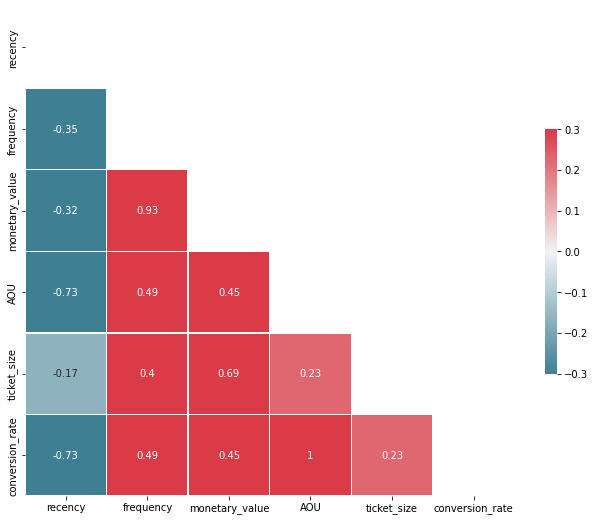

In [19]:
# Create the correlation matrix
corr = df_clv.corr()

# Generate a mask for the upper triangle; True = do NOT show
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio

# More details at https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(
    corr,          # The data to plot
    mask=mask,     # Mask some cells
    cmap=cmap,     # What colors to plot the heatmap as
    annot=True,    # Should the values be plotted in the cells?
    vmax=.3,       # The maximum value of the legend. All higher vals will be same color
    vmin=-.3,      # The minimum value of the legend. All lower vals will be same color
    center=0,      # The center value of the legend. With divergent cmap, where white is
    square=True,   # Force cells to be square
    linewidths=.5, # Width of lines that divide cells
    cbar_kws={"shrink": .5}  # Extra kwargs for the legend; in this case, shrink by 50%
)

# You can save this as a png with
# f.savefig('heatmap_colored_correlation_matrix_seaborn_python.png')

## **Calculating response rate**

In [20]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

#  groupby response นับ customer id รวม   check Imbalance data
# คนไม่เคยใช้ campaign เยอะมากๆ = 0, เคยใช้ =1

,response,customer_id
0,0,6237
1,1,647


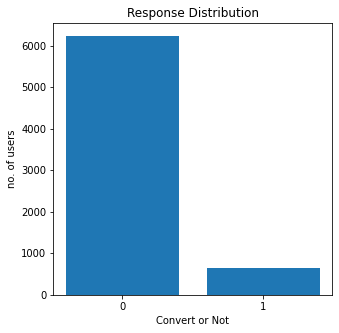

In [21]:
plt.figure(figsize=(5,5))                   # เอามา plot พบว่า Data Imbalance มาก
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [ ]:
## merging two data sets - RFM

# merge df_response, df_rfm

df_modeling_rfm = pd.merge(df_response,df_rfm)
df_modeling_rfm.head()
# column id ต้องเก็บไว้เช็คว่้าเป็นของใคร ใช้ทำนายไม่ได้

,customer_id,response,recency,frequency,monetary_value
0,CS1112,0,62.0,7,463
1,CS1113,0,36.0,12,872
2,CS1114,1,33.0,12,856
3,CS1115,1,12.0,12,925
4,CS1116,1,204.0,6,392


In [ ]:
## merging two data sets - CLV
# merge df_response, df_clv

df_modeling_clv = pd.merge(df_response,df_clv)
df_modeling_clv.head()

,customer_id,response,recency,frequency,monetary_value,AOU,ticket_size,conversion_rate
0,CS1112,0,62.0,7,463,684,66.142857,9.93
1,CS1113,0,36.0,12,872,705,72.666667,10.24
2,CS1114,1,33.0,12,856,756,71.333333,10.98
3,CS1115,1,12.0,12,925,775,77.083333,11.25
4,CS1116,1,204.0,6,392,598,65.333333,8.68


## **3.) Creating train and test dataset**

In [ ]:
## spliting dataframe into X and y
# ไม่เอา 'response','customer_id' ไป predict

X_rfm = df_modeling_rfm.drop(columns=['response','customer_id'])
y_rfm = df_modeling_rfm['response']

X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
y_clv = df_modeling_clv['response']

In [ ]:
## creating train and test dataset

X_train_rfm, X_test_rfm, y_train_rfm, y_test_rfm = train_test_split(X_rfm.values, y_rfm.values, test_size=0.3, random_state=0)
X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv.values, y_clv.values, test_size=0.3, random_state=0)

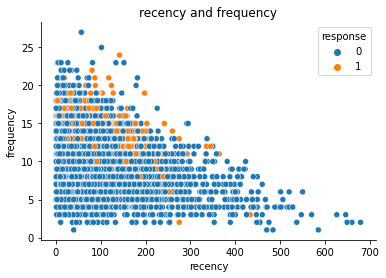

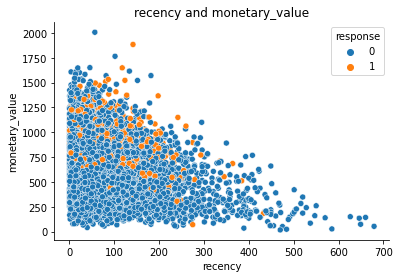

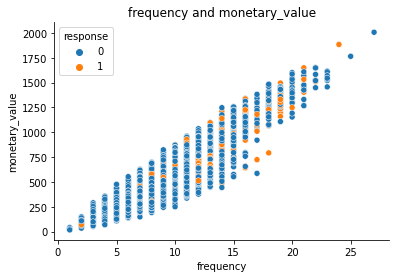

In [ ]:
for i, col_i in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
  for j, col_j in enumerate(df_modeling_rfm[['recency', 'frequency', 'monetary_value']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_rfm, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

# plot scatter ว่า response กับ ไม่ response เป็นไงบ้าง เอามา plot 
# plot 'recency', 'frequency'
# plot 'recency','monetary_value' กระจายมาก
# plot 'frequency', 'monetary_value' 

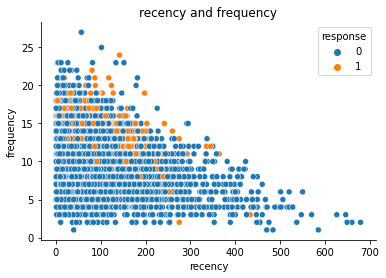

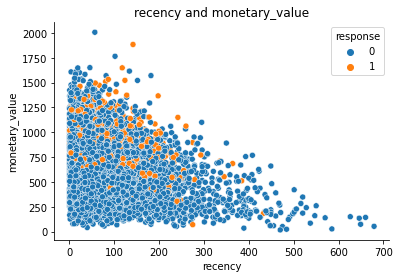

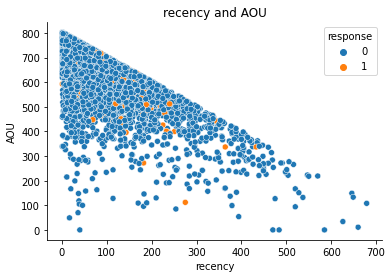

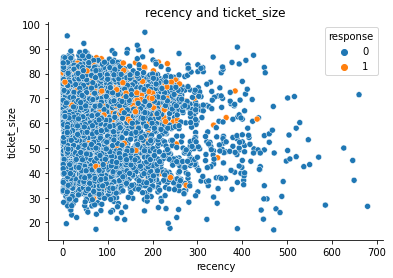

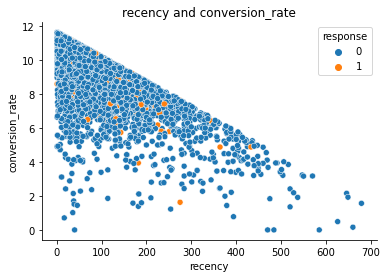

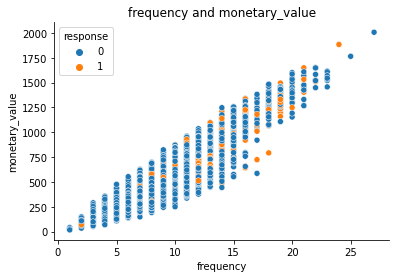

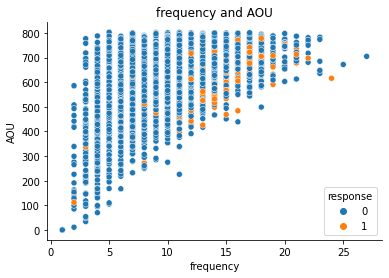

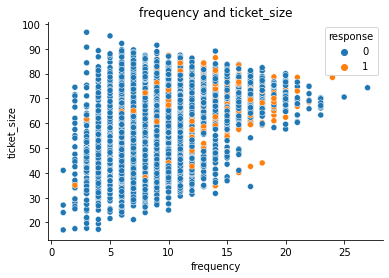

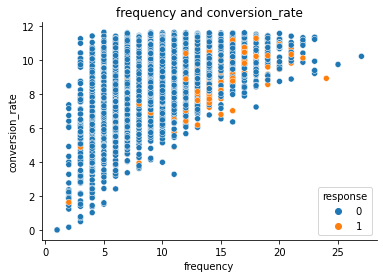

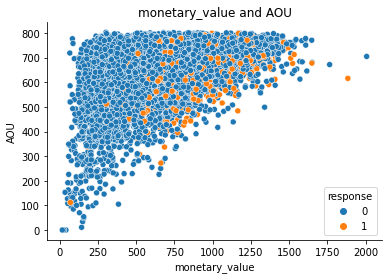

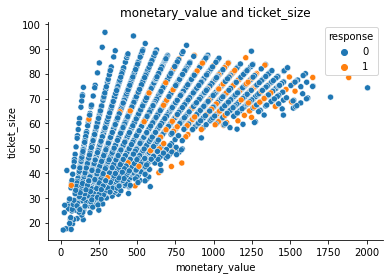

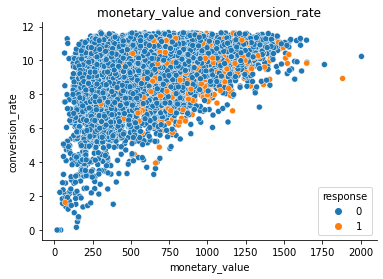

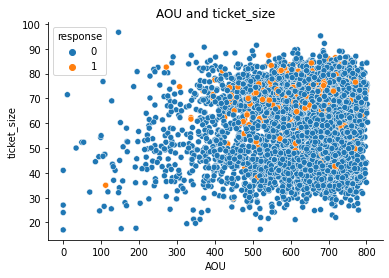

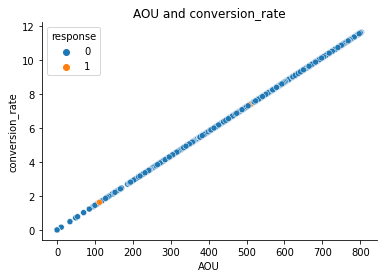

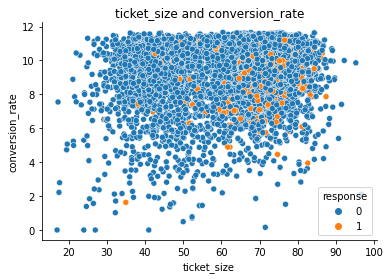

In [ ]:
for i, col_i in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size', 'conversion_rate']].columns):
  for j, col_j in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size', 'conversion_rate']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_clv, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

# จับคู่ plot วน 

#### **Fixing imbalanced with SMOTE**

In [ ]:
sm = SMOTE(random_state=0)

sm.fit(X_train_rfm, y_train_rfm)
X_SMOTE_rfm, y_SMOTE_rfm = sm.fit_resample(X_train_rfm, y_train_rfm)

sm.fit(X_train_clv, y_train_clv)
X_SMOTE_clv, y_SMOTE_clv = sm.fit_resample(X_train_clv, y_train_clv)

## **4.) Model Selection**

### **Comparison Model by Accuracy score**

Model Selection  
- LogisticRegression  
- DecisionTreeClassifier  
- KNeighborsClassifier  
- RandomForestClassifier  
- GradientBoostingClassifier  
- XGBClassifier  

In [ ]:
#Model Selection
logreg = LogisticRegression()
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier()
forest = RandomForestClassifier()
grad_clf = GradientBoostingClassifier()
xgb_clf = XGBClassifier()
  
cv_dict = {0: 'LogisticRegression',1: 'DecisionTreeClassifier', 2:'KNeighborsClassifier'
           , 3:'RandomForestClassifier', 4:'GradientBoostingClassifier', 5:'XGBClassifier'}    
cv_models=[logreg, dt, knn, forest, grad_clf, xgb_clf]

print("Comparison performance rfm model")
for i,model in enumerate(cv_models):
    print("\n{} Test Accuracy_CV: {}".format(cv_dict[i],cross_val_score(model, X_SMOTE_rfm, y_SMOTE_rfm, cv=10, scoring ='accuracy').mean()))

print("Comparison performance clv model")
for i,model in enumerate(cv_models):
    print("\n{} Test Accuracy_CV: {}".format(cv_dict[i],cross_val_score(model, X_SMOTE_clv, y_SMOTE_clv, cv=10, scoring ='accuracy').mean()))

Comparison performance rfm model

LogisticRegression Test Accuracy_CV: 0.7069934519990755

DecisionTreeClassifier Test Accuracy_CV: 0.9032882860653034

KNeighborsClassifier Test Accuracy_CV: 0.8213750282465331

RandomForestClassifier Test Accuracy_CV: 0.9204872429565484

GradientBoostingClassifier Test Accuracy_CV: 0.8376673688256974

XGBClassifier Test Accuracy_CV: 0.835047129502887
Comparison performance clv model

LogisticRegression Test Accuracy_CV: 0.7163358467336619

DecisionTreeClassifier Test Accuracy_CV: 0.8973602803095039

KNeighborsClassifier Test Accuracy_CV: 0.8530417944795236

RandomForestClassifier Test Accuracy_CV: 0.9195749124032799

GradientBoostingClassifier Test Accuracy_CV: 0.8372099697924431

XGBClassifier Test Accuracy_CV: 0.8299178188221911


In [ ]:
#  Comparison rfm Model by Precision, Recall, f1 Score

logreg.fit(X_SMOTE_rfm, y_SMOTE_rfm)
logreg_pred = logreg.predict(X_test_rfm.values)
print('\n',confusion_matrix(y_test_rfm, logreg_pred))
print('LogisticRegression Precision Score: ', precision_score(y_test_rfm, logreg_pred))
print('LogisticRegression Recall Score: ', recall_score(y_test_rfm, logreg_pred))
print('LogisticRegression f1 Score: ', f1_score(y_test_rfm, logreg_pred))


dt.fit(X_SMOTE_rfm, y_SMOTE_rfm)
dt_pred = dt.predict(X_test_rfm.values)
print('\n',confusion_matrix(y_test_rfm, dt_pred))
print('DecisionTreeClassifier Precision Score: ', precision_score(y_test_rfm, dt_pred))
print('DecisionTreeClassifier Recall Score: ', recall_score(y_test_rfm, dt_pred))
print('DecisionTreeClassifier f1 Score: ', f1_score(y_test_rfm, dt_pred))


knn.fit(X_SMOTE_rfm, y_SMOTE_rfm)
knn_pred = knn.predict(X_test_rfm.values)
print('\n',confusion_matrix(y_test_rfm, knn_pred))
print('KNeighborsClassifier Precision Score: ', precision_score(y_test_rfm, knn_pred))
print('KNeighborsClassifier Recall Score: ', recall_score(y_test_rfm, knn_pred))
print('KNeighborsClassifier f1 Score: ', f1_score(y_test_rfm, knn_pred))


forest.fit(X_SMOTE_rfm, y_SMOTE_rfm)
forest_pred = forest.predict(X_test_rfm.values)
print('\n',confusion_matrix(y_test_rfm, forest_pred))
print('RandomForestClassifier Precision Score: ', precision_score(y_test_rfm, forest_pred))
print('RandomForestClassifier Recall Score: ', recall_score(y_test_rfm, forest_pred))
print('RandomForestClassifier f1 Score: ', f1_score(y_test_rfm, forest_pred))

grad_clf.fit(X_SMOTE_rfm, y_SMOTE_rfm)
grad_clf_pred = grad_clf.predict(X_test_rfm.values)
print('\n',confusion_matrix(y_test_rfm, grad_clf_pred))
print('GradientBoostingClassifier Precision Score: ', precision_score(y_test_rfm, grad_clf_pred))
print('GradientBoostingClassifier Recall Score: ', recall_score(y_test_rfm, grad_clf_pred))
print('GradientBoostingClassifier f1 Score: ', f1_score(y_test_rfm, grad_clf_pred))

xgb_clf.fit(X_SMOTE_rfm, y_SMOTE_rfm)
xgb_clf_pred = xgb_clf.predict(X_test_rfm.values)
print('\n',confusion_matrix(y_test_rfm, xgb_clf_pred))
print('XGBClassifier Precision Score: ', precision_score(y_test_rfm, xgb_clf_pred))
print('XGBClassifier Recall Score: ', recall_score(y_test_rfm, xgb_clf_pred))
print('XGBClassifier f1 Score: ', f1_score(y_test_rfm, xgb_clf_pred))


 [[1290  593]
 [  52  131]]
LogisticRegression Precision Score:  0.18093922651933703
LogisticRegression Recall Score:  0.7158469945355191
LogisticRegression f1 Score:  0.288864388092613

 [[1824   59]
 [  51  132]]
DecisionTreeClassifier Precision Score:  0.6910994764397905
DecisionTreeClassifier Recall Score:  0.7213114754098361
DecisionTreeClassifier f1 Score:  0.7058823529411764

 [[1497  386]
 [  39  144]]
KNeighborsClassifier Precision Score:  0.27169811320754716
KNeighborsClassifier Recall Score:  0.7868852459016393
KNeighborsClassifier f1 Score:  0.40392706872370265

 [[1838   45]
 [  51  132]]
RandomForestClassifier Precision Score:  0.7457627118644068
RandomForestClassifier Recall Score:  0.7213114754098361
RandomForestClassifier f1 Score:  0.7333333333333334

 [[1524  359]
 [  72  111]]
GradientBoostingClassifier Precision Score:  0.23617021276595745
GradientBoostingClassifier Recall Score:  0.6065573770491803
GradientBoostingClassifier f1 Score:  0.33996937212863704

 [[152

In [ ]:
#  Comparison clv Model by Precision, Recall, f1 Score

logreg.fit(X_SMOTE_clv, y_SMOTE_clv)
logreg_pred = logreg.predict(X_test_clv.values)
print('\n',confusion_matrix(y_test_clv, logreg_pred))
print('LogisticRegression Precision Score: ', precision_score(y_test_clv, logreg_pred))
print('LogisticRegression Recall Score: ', recall_score(y_test_clv, logreg_pred))
print('LogisticRegression f1 Score: ', f1_score(y_test_clv, logreg_pred))


dt.fit(X_SMOTE_clv, y_SMOTE_clv)
dt_pred = dt.predict(X_test_clv.values)
print('\n',confusion_matrix(y_test_clv, dt_pred))
print('DecisionTreeClassifier Precision Score: ', precision_score(y_test_clv, dt_pred))
print('DecisionTreeClassifier Recall Score: ', recall_score(y_test_clv, dt_pred))
print('DecisionTreeClassifier f1 Score: ', f1_score(y_test_clv, dt_pred))


knn.fit(X_SMOTE_clv, y_SMOTE_clv)
knn_pred = knn.predict(X_test_clv.values)
print('\n',confusion_matrix(y_test_clv, knn_pred))
print('KNeighborsClassifier Precision Score: ', precision_score(y_test_clv, knn_pred))
print('KNeighborsClassifier Recall Score: ', recall_score(y_test_clv, knn_pred))
print('KNeighborsClassifier f1 Score: ', f1_score(y_test_clv, knn_pred))


forest.fit(X_SMOTE_clv, y_SMOTE_clv)
forest_pred = forest.predict(X_test_clv.values)
print('\n',confusion_matrix(y_test_clv, forest_pred))
print('RandomForestClassifier Precision Score: ', precision_score(y_test_clv, forest_pred))
print('RandomForestClassifier Recall Score: ', recall_score(y_test_clv, forest_pred))
print('RandomForestClassifier f1 Score: ', f1_score(y_test_clv, forest_pred))

grad_clf.fit(X_SMOTE_clv, y_SMOTE_clv)
grad_clf_pred = grad_clf.predict(X_test_clv.values)
print('\n',confusion_matrix(y_test_clv, grad_clf_pred))
print('GradientBoostingClassifier Precision Score: ', precision_score(y_test_clv, grad_clf_pred))
print('GradientBoostingClassifier Recall Score: ', recall_score(y_test_clv, grad_clf_pred))
print('GradientBoostingClassifier f1 Score: ', f1_score(y_test_clv, grad_clf_pred))

xgb_clf.fit(X_SMOTE_clv, y_SMOTE_clv)
xgb_clf_pred = xgb_clf.predict(X_test_clv.values)
print('\n',confusion_matrix(y_test_clv, xgb_clf_pred))
print('XGBClassifier Precision Score: ', precision_score(y_test_clv, xgb_clf_pred))
print('XGBClassifier Recall Score: ', recall_score(y_test_clv, xgb_clf_pred))
print('XGBClassifier f1 Score: ', f1_score(y_test_clv, xgb_clf_pred))


 [[1270  613]
 [  43  140]]
LogisticRegression Precision Score:  0.18592297476759628
LogisticRegression Recall Score:  0.7650273224043715
LogisticRegression f1 Score:  0.2991452991452991

 [[1818   65]
 [  47  136]]
DecisionTreeClassifier Precision Score:  0.6766169154228856
DecisionTreeClassifier Recall Score:  0.7431693989071039
DecisionTreeClassifier f1 Score:  0.7083333333333335

 [[1510  373]
 [  36  147]]
KNeighborsClassifier Precision Score:  0.2826923076923077
KNeighborsClassifier Recall Score:  0.8032786885245902
KNeighborsClassifier f1 Score:  0.41820768136557607

 [[1830   53]
 [  44  139]]
RandomForestClassifier Precision Score:  0.7239583333333334
RandomForestClassifier Recall Score:  0.7595628415300546
RandomForestClassifier f1 Score:  0.7413333333333334

 [[1529  354]
 [  70  113]]
GradientBoostingClassifier Precision Score:  0.24197002141327623
GradientBoostingClassifier Recall Score:  0.6174863387978142
GradientBoostingClassifier f1 Score:  0.3476923076923077

 [[1499

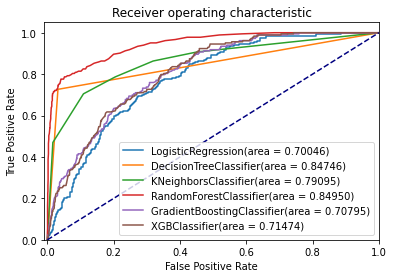

In [ ]:
#ROC Curve rfm

logreg.fit(X_SMOTE_rfm, y_SMOTE_rfm)
logreg_roc_auc = roc_auc_score(y_test_rfm, logreg.predict(X_test_rfm.values))
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test_rfm, logreg.predict_proba(X_test_rfm.values)[:,1])

dt.fit(X_SMOTE_rfm, y_SMOTE_rfm)
dt_roc_auc = roc_auc_score(y_test_rfm, dt.predict(X_test_rfm.values))
fpr_dt, tpr_dt, thresholds_knn = roc_curve(y_test_rfm, dt.predict_proba(X_test_rfm.values)[:,1])

knn.fit(X_SMOTE_rfm, y_SMOTE_rfm)
knn_roc_auc = roc_auc_score(y_test_rfm, knn.predict(X_test_rfm.values))
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test_rfm, knn.predict_proba(X_test_rfm.values)[:,1])

forest.fit(X_SMOTE_rfm, y_SMOTE_rfm)
forest_roc_auc = roc_auc_score(y_test_rfm, forest.predict(X_test_rfm.values))
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_test_rfm, forest.predict_proba(X_test_rfm.values)[:,1])

grad_clf.fit(X_SMOTE_rfm, y_SMOTE_rfm)
grad_clf_roc_auc = roc_auc_score(y_test_rfm, grad_clf.predict(X_test_rfm.values))
fpr_grad_clf, tpr_grad_clf, thresholds_grad_clf = roc_curve(y_test_rfm, grad_clf.predict_proba(X_test_rfm.values)[:,1])

xgb_clf.fit(X_SMOTE_rfm, y_SMOTE_rfm)
xgb_clf_roc_auc = roc_auc_score(y_test_rfm, xgb_clf.predict(X_test_rfm.values))
fpr_xgb_clf, tpr_xgb_clf, thresholds_xgb_clf = roc_curve(y_test_rfm, xgb_clf.predict_proba(X_test_rfm.values)[:,1])

plt.figure()
plt.plot(fpr_logreg, tpr_logreg, label='LogisticRegression(area = %0.5f)' % logreg_roc_auc)
plt.plot(fpr_dt, tpr_dt, label='DecisionTreeClassifier(area = %0.5f)' % dt_roc_auc)
plt.plot(fpr_knn, tpr_knn, label='KNeighborsClassifier(area = %0.5f)' % knn_roc_auc)
plt.plot(fpr_forest, tpr_forest, label='RandomForestClassifier(area = %0.5f)' % forest_roc_auc)
plt.plot(fpr_grad_clf, tpr_grad_clf, label='GradientBoostingClassifier(area = %0.5f)' % grad_clf_roc_auc)
plt.plot(fpr_xgb_clf, tpr_xgb_clf, label='XGBClassifier(area = %0.5f)' % xgb_clf_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

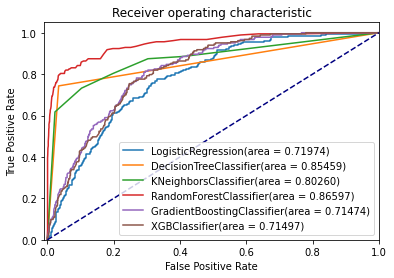

In [ ]:
#ROC clv Curve

logreg.fit(X_SMOTE_clv, y_SMOTE_clv)
logreg_roc_auc = roc_auc_score(y_test_clv, logreg.predict(X_test_clv.values))
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test_clv, logreg.predict_proba(X_test_clv.values)[:,1])

dt.fit(X_SMOTE_clv, y_SMOTE_clv)
dt_roc_auc = roc_auc_score(y_test_clv, dt.predict(X_test_clv.values))
fpr_dt, tpr_dt, thresholds_knn = roc_curve(y_test_clv, dt.predict_proba(X_test_clv.values)[:,1])

knn.fit(X_SMOTE_clv, y_SMOTE_clv)
knn_roc_auc = roc_auc_score(y_test_clv, knn.predict(X_test_clv.values))
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test_clv, knn.predict_proba(X_test_clv.values)[:,1])

forest.fit(X_SMOTE_clv, y_SMOTE_clv)
forest_roc_auc = roc_auc_score(y_test_clv, forest.predict(X_test_clv.values))
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_test_clv, forest.predict_proba(X_test_clv.values)[:,1])

grad_clf.fit(X_SMOTE_clv, y_SMOTE_clv)
grad_clf_roc_auc = roc_auc_score(y_test_clv, grad_clf.predict(X_test_clv.values))
fpr_grad_clf, tpr_grad_clf, thresholds_grad_clf = roc_curve(y_test_clv, grad_clf.predict_proba(X_test_clv.values)[:,1])

xgb_clf.fit(X_SMOTE_clv, y_SMOTE_clv)
xgb_clf_roc_auc = roc_auc_score(y_test_clv, xgb_clf.predict(X_test_clv.values))
fpr_xgb_clf, tpr_xgb_clf, thresholds_xgb_clf = roc_curve(y_test_clv, xgb_clf.predict_proba(X_test_clv.values)[:,1])

plt.figure()
plt.plot(fpr_logreg, tpr_logreg, label='LogisticRegression(area = %0.5f)' % logreg_roc_auc)
plt.plot(fpr_dt, tpr_dt, label='DecisionTreeClassifier(area = %0.5f)' % dt_roc_auc)
plt.plot(fpr_knn, tpr_knn, label='KNeighborsClassifier(area = %0.5f)' % knn_roc_auc)
plt.plot(fpr_forest, tpr_forest, label='RandomForestClassifier(area = %0.5f)' % forest_roc_auc)
plt.plot(fpr_grad_clf, tpr_grad_clf, label='GradientBoostingClassifier(area = %0.5f)' % grad_clf_roc_auc)
plt.plot(fpr_xgb_clf, tpr_xgb_clf, label='XGBClassifier(area = %0.5f)' % xgb_clf_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### **4.1) Logistic Regression**

In [ ]:
print('logistic regression model - SMOTE RFM')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_rfm = logreg.fit(X_SMOTE_rfm, y_SMOTE_rfm)
predictions = logreg_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)  #.extend เพื่อดู y_hat ที่ทำนาย print ออกมา
expected_y.extend(y_SMOTE_rfm)   #.extend เพื่อดู y จริง print ออกมา
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 
print('AUC Score',roc_auc_score(expected_y,predicted_y))  

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_rfm.predict(X_test_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 
print('AUC Score',roc_auc_score(expected_y,predicted_y))

logistic regression model - SMOTE RFM
training set
              precision    recall  f1-score   support

           0       0.72      0.69      0.70      4389
           1       0.70      0.73      0.71      4389

    accuracy                           0.71      8778
   macro avg       0.71      0.71      0.71      8778
weighted avg       0.71      0.71      0.71      8778

AUC Score 0.7073365231259968
test set
              precision    recall  f1-score   support

           0       0.96      0.68      0.80      1848
           1       0.22      0.74      0.34       218

    accuracy                           0.69      2066
   macro avg       0.59      0.71      0.57      2066
weighted avg       0.88      0.69      0.75      2066

AUC Score 0.7138215377894277


In [ ]:
print('logistic regression model - SMOTE CLV')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_clv = logreg.fit(X_SMOTE_clv, y_SMOTE_clv)
predictions = logreg_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 
print('AUC Score',roc_auc_score(expected_y,predicted_y))  

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_clv.predict(X_test_clv)
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 
print('AUC Score',roc_auc_score(expected_y,predicted_y))  

logistic regression model - SMOTE CLV
training set
              precision    recall  f1-score   support

           0       0.73      0.69      0.71      4389
           1       0.71      0.74      0.72      4389

    accuracy                           0.72      8778
   macro avg       0.72      0.72      0.72      8778
weighted avg       0.72      0.72      0.72      8778

AUC Score 0.7153110047846889
test set
              precision    recall  f1-score   support

           0       0.96      0.68      0.80      1848
           1       0.21      0.73      0.33       218

    accuracy                           0.69      2066
   macro avg       0.59      0.71      0.56      2066
weighted avg       0.88      0.69      0.75      2066

AUC Score 0.7081521307438737


### **4.2) XGBoost**

In [ ]:
print('XGBoost model - SMOTE RFM')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE_rfm = xgb_model.fit(X_SMOTE_rfm, y_SMOTE_rfm, early_stopping_rounds=5, eval_set=[(np.array(X_test_rfm), y_test_rfm)])

predictions =  xgb_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 
print('AUC Score',roc_auc_score(expected_y,predicted_y))  

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_rfm.predict(np.array(X_test_rfm))
predicted_y.extend(predictions)
expected_y.extend(y_test_rfm)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 
print('AUC Score',roc_auc_score(expected_y,predicted_y))  

# ไม่ improve ใน 5 รอบ stop

XGBoost model - SMOTE RFM
[0]	validation_0-auc:0.567615
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.750307
[2]	validation_0-auc:0.747251
[3]	validation_0-auc:0.732802
[4]	validation_0-auc:0.744314
[5]	validation_0-auc:0.750307
[6]	validation_0-auc:0.747991
Stopping. Best iteration:
[1]	validation_0-auc:0.750307

training set
              precision    recall  f1-score   support

           0       0.77      0.65      0.71      4389
           1       0.70      0.80      0.75      4389

    accuracy                           0.73      8778
   macro avg       0.73      0.73      0.73      8778
weighted avg       0.73      0.73      0.73      8778

AUC Score 0.7276144907723855
test set
              precision    recall  f1-score   support

           0       0.96      0.65      0.77      1848
           1       0.20      0.76      0.32       218

    accuracy                           0.66      2066
   macro avg       0.58      0.70      0.55     

In [ ]:
print('XGBoost model - SMOTE CLV')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=150,
 max_depth=3,
 gamma=0.1,
 colsample_bytree=0.7)

predicted_y = []
expected_y = []

xgb_model_SMOTE_clv = xgb_model.fit(X_SMOTE_clv, y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(np.array(X_test_clv), y_test_clv)])
predictions =  xgb_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 
print('AUC Score',roc_auc_score(expected_y,predicted_y))  

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_clv.predict(np.array(X_test_clv))
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 
print('AUC Score',roc_auc_score(expected_y,predicted_y))  


XGBoost model - SMOTE CLV
[0]	validation_0-auc:0.751807
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.751807
[2]	validation_0-auc:0.752996
[3]	validation_0-auc:0.753095
[4]	validation_0-auc:0.753095
[5]	validation_0-auc:0.779934
[6]	validation_0-auc:0.782531
[7]	validation_0-auc:0.791531
[8]	validation_0-auc:0.789965
[9]	validation_0-auc:0.789074
[10]	validation_0-auc:0.788726
[11]	validation_0-auc:0.78829
[12]	validation_0-auc:0.788376
Stopping. Best iteration:
[7]	validation_0-auc:0.791531

training set
              precision    recall  f1-score   support

           0       0.83      0.63      0.72      4389
           1       0.70      0.87      0.78      4389

    accuracy                           0.75      8778
   macro avg       0.77      0.75      0.75      8778
weighted avg       0.77      0.75      0.75      8778

AUC Score 0.7511961722488038
test set
              precision    recall  f1-score   support

           0       0.97      

### Tunning rfm Model

In [ ]:
# A parameter grid for XGBoost
params = {
        'n_estimators': [5, 10, 15, 20, 25, 50, 60, 100, 220],
        'learning_rate': [0.01, 0.05, 0.1],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
#        'max_depth': [3, 4, 5]
        }

In [ ]:
clf = GridSearchCV(estimator=xgb_model_SMOTE_rfm, 
                   param_grid=params,  
                   cv=10, 
                   n_jobs=10,
                   scoring='roc_auc',
                   verbose=True, 
                   refit=True)

In [ ]:
clf.fit(X_SMOTE_rfm, y_SMOTE_rfm)

Fitting 10 folds for each of 3645 candidates, totalling 36450 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(colsample_bytree=0.6, eval_metric='auc',
                                     gamma=0.0, learning_rate=0.01,
                                     max_depth=2),
             n_jobs=10,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2, 5],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'min_child_weight': [1, 5, 10],
                         'n_estimators': [5, 10, 15, 20, 25, 50, 60, 100, 220],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='roc_auc', verbose=True)

In [ ]:
clf.best_estimator_

XGBClassifier(colsample_bytree=1.0, eval_metric='auc', gamma=1, max_depth=2,
              min_child_weight=5, n_estimators=220, subsample=1.0)

In [ ]:
# best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
# print('Raw AUC score:', score)
# for param_name in sorted(best_parameters.keys()):
#     print("%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
xgb_model_rfm = XGBClassifier(colsample_bytree=1.0, eval_metric='auc', gamma=1, max_depth=2,
              min_child_weight=5, n_estimators=220, subsample=1.0)

In [ ]:
predicted_y = []
expected_y = []

xgb_model_SMOTE_rfm = xgb_model_rfm.fit(X_SMOTE_rfm, y_SMOTE_rfm, early_stopping_rounds=5, eval_set=[(np.array(X_test_rfm), y_test_rfm)])
predictions =  xgb_model_SMOTE_rfm.predict(X_SMOTE_rfm)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_rfm)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 
print('AUC Score',roc_auc_score(expected_y,predicted_y))  

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_rfm.predict(np.array(X_test_rfm))
predicted_y.extend(predictions)
expected_y.extend(y_test_rfm)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 
print('AUC Score',roc_auc_score(expected_y,predicted_y))  

[0]	validation_0-auc:0.729106
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.740103
[2]	validation_0-auc:0.778562
[3]	validation_0-auc:0.778427
[4]	validation_0-auc:0.776537
[5]	validation_0-auc:0.779948
[6]	validation_0-auc:0.784266
[7]	validation_0-auc:0.785172
[8]	validation_0-auc:0.785407
[9]	validation_0-auc:0.784997
[10]	validation_0-auc:0.786176
[11]	validation_0-auc:0.786274
[12]	validation_0-auc:0.787278
[13]	validation_0-auc:0.787801
[14]	validation_0-auc:0.789548
[15]	validation_0-auc:0.793114
[16]	validation_0-auc:0.794098
[17]	validation_0-auc:0.794046
[18]	validation_0-auc:0.794345
[19]	validation_0-auc:0.794388
[20]	validation_0-auc:0.794844
[21]	validation_0-auc:0.794307
[22]	validation_0-auc:0.794098
[23]	validation_0-auc:0.795082
[24]	validation_0-auc:0.795317
[25]	validation_0-auc:0.795015
[26]	validation_0-auc:0.795442
[27]	validation_0-auc:0.795781
[28]	validation_0-auc:0.795717
[29]	validation_0-auc:0.795445
[30]	validation_0

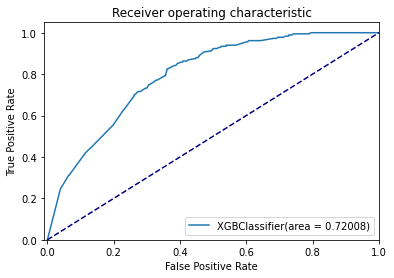

In [ ]:
#ROC Curve

# xgb_clf_rfm.fit(X_SMOTE_rfm, y_SMOTE_rfm)
xgb_clf_roc_auc = roc_auc_score(y_test_rfm, xgb_model_SMOTE_rfm.predict(X_test_rfm.values))
fpr_xgb_clf, tpr_xgb_clf, thresholds_xgb_clf = roc_curve(y_test_rfm, 
                                                         xgb_model_SMOTE_rfm.predict_proba(X_test_rfm.values)[:,1])

plt.figure()
plt.plot(fpr_xgb_clf, tpr_xgb_clf, label='XGBClassifier(area = %0.5f)' % xgb_clf_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print(predictions)

[1 1 0 ... 1 1 1]


### Tuning clv Model 

In [ ]:
clf = GridSearchCV(estimator=xgb_model_SMOTE_clv, 
                   param_grid=params,  
                   cv=10, 
                   n_jobs=10,
                   scoring='roc_auc',
                   verbose=True, 
                   refit=True)

In [ ]:
clf.fit(X_SMOTE_rfm, y_SMOTE_rfm)

Fitting 10 folds for each of 3645 candidates, totalling 36450 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(colsample_bytree=1.0, eval_metric='auc',
                                     gamma=1, max_depth=2, min_child_weight=5,
                                     n_estimators=220, subsample=1.0),
             n_jobs=10,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2, 5],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'min_child_weight': [1, 5, 10],
                         'n_estimators': [5, 10, 15, 20, 25, 50, 60, 100, 220],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='roc_auc', verbose=True)

In [ ]:
clf.best_estimator_

XGBClassifier(colsample_bytree=1.0, eval_metric='auc', gamma=1, max_depth=2,
              min_child_weight=5, n_estimators=220, subsample=1.0)

In [ ]:
xgb = XGBClassifier(colsample_bytree=1.0, eval_metric='auc', gamma=1, max_depth=2,
              min_child_weight=5, n_estimators=220, subsample=1.0)

In [ ]:
predicted_y = []
expected_y = []

xgb_model_SMOTE_clv = xgb_model.fit(X_SMOTE_clv, y_SMOTE_clv, early_stopping_rounds=5, eval_set=[(np.array(X_test_clv), y_test_clv)])
predictions =  xgb_model_SMOTE_clv.predict(X_SMOTE_clv)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE_clv)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 
print('AUC Score',roc_auc_score(expected_y,predicted_y))  

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_clv.predict(np.array(X_test_clv))
predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 
print('AUC Score',roc_auc_score(expected_y,predicted_y))  

[0]	validation_0-auc:0.742432
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.742432
[2]	validation_0-auc:0.777873
[3]	validation_0-auc:0.776103
[4]	validation_0-auc:0.786972
[5]	validation_0-auc:0.78865
[6]	validation_0-auc:0.789808
[7]	validation_0-auc:0.789622
[8]	validation_0-auc:0.789765
[9]	validation_0-auc:0.790256
[10]	validation_0-auc:0.790362
[11]	validation_0-auc:0.791089
[12]	validation_0-auc:0.793302
[13]	validation_0-auc:0.793197
[14]	validation_0-auc:0.792942
[15]	validation_0-auc:0.798274
[16]	validation_0-auc:0.797491
[17]	validation_0-auc:0.799455
[18]	validation_0-auc:0.800163
[19]	validation_0-auc:0.800484
[20]	validation_0-auc:0.801146
[21]	validation_0-auc:0.801172
[22]	validation_0-auc:0.80233
[23]	validation_0-auc:0.802447
[24]	validation_0-auc:0.802751
[25]	validation_0-auc:0.802304
[26]	validation_0-auc:0.802665
[27]	validation_0-auc:0.802954
[28]	validation_0-auc:0.802582
[29]	validation_0-auc:0.8028
[30]	validation_0-auc

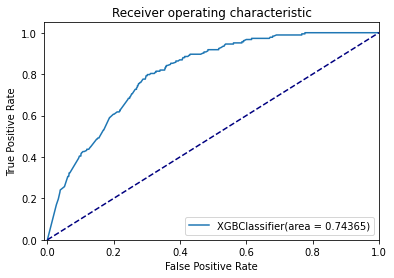

In [ ]:
#ROC Curve

xgb_clf_roc_auc = roc_auc_score(y_test_clv, xgb_model_SMOTE_clv.predict(X_test_clv.values))
fpr_xgb_clf, tpr_xgb_clf, thresholds_xgb_clf = roc_curve(y_test_clv, 
                                                         xgb_model_SMOTE_clv.predict_proba(X_test_clv.values)[:,1])

plt.figure()
plt.plot(fpr_xgb_clf, tpr_xgb_clf, label='XGBClassifier(area = %0.5f)' % xgb_clf_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print(predictions)

[1 1 0 ... 1 1 1]


## **The best model is XGBoost model - SMOTE RFM**  
AUC Score for training data = 0.7807017543859649, AUC Score for test data = 0.7200839260684467  

## **The best model is XGBoost model - SMOTE CLV**  
AUC Score for training data =  0.7885623148781042, AUC Score for test data = 0.743646779206533  